### 1. 数据预处理
- 只取国内地震数据
- 数据里的日期（年月日）合并处理为datetime格式，形如1970-01-05
- 存在同一日多地出现地震的情况，取当日震级最大值

In [36]:
import pandas as pd

# 地震目录数据路径
io = r'D:\jupyter_project\ARIMA\data\earthquake1970_5+.xlsx'

In [37]:
# 提取国内地震数据
df = pd.read_excel(io, usecols = [1, 2, 3, 10, 11])
df_eq = df.loc[df.国内外 == '国内']
df_eq

,年,月,日,震级,国内外
0,1970,1,5,7.8,国内
1,1970,1,5,5.2,国内
2,1970,1,5,5.5,国内
3,1970,1,5,5.9,国内
4,1970,1,5,5.3,国内
...,...,...,...,...,...
2059,2018,11,26,6.2,国内
2060,2018,12,16,5.2,国内
2061,2018,12,16,5.7,国内
2062,2018,12,20,5.2,国内


In [38]:
# 拼接年月日到新的列：date_time中，并格式化为datetime日期格式，形如1970-01-05
# 解决直接往DataFrame新增列的warning，copy到x中再进行操作
x = pd.DataFrame(df_eq)
x.loc[:, 'date_time'] = pd.to_datetime(df_eq['年'].map(str)+'-'+df_eq['月'].map(str)+'-'+df_eq['日'].map(str))
x

,年,月,日,震级,国内外,date_time
0,1970,1,5,7.8,国内,1970-01-05
1,1970,1,5,5.2,国内,1970-01-05
2,1970,1,5,5.5,国内,1970-01-05
3,1970,1,5,5.9,国内,1970-01-05
4,1970,1,5,5.3,国内,1970-01-05
...,...,...,...,...,...,...
2059,2018,11,26,6.2,国内,2018-11-26
2060,2018,12,16,5.2,国内,2018-12-16
2061,2018,12,16,5.7,国内,2018-12-16
2062,2018,12,20,5.2,国内,2018-12-20


In [39]:
# 按日期分组后取最大值，即仅保留当日最大震级
df_eq_max = x.groupby('date_time').max()
df_eq_max

,年,月,日,震级,国内外
date_time,,,,,
1970-01-05,1970,1,5,7.8,国内
1970-01-09,1970,1,9,5.0,国内
1970-01-14,1970,1,14,5.4,国内
1970-02-05,1970,2,5,5.7,国内
1970-02-07,1970,2,7,6.2,国内
...,...,...,...,...,...
2018-11-04,2018,11,4,5.1,国内
2018-11-26,2018,11,26,6.2,国内
2018-12-16,2018,12,16,5.7,国内


In [40]:
# 只提取日期+震级(共1549条数据)
df_eq_date = df_eq_max['震级']
df_eq_date

date_time
1970-01-05    7.8
1970-01-09    5.0
1970-01-14    5.4
1970-02-05    5.7
1970-02-07    6.2
             ... 
2018-11-04    5.1
2018-11-26    6.2
2018-12-16    5.7
2018-12-20    5.2
2018-12-24    5.8
Name: 震级, Length: 1549, dtype: float64

In [41]:
# 导出为csv方便使用
output_path='./data/eq_date.csv'
df_eq_date.to_csv(output_path,sep=',',index=True,header=True)

### 2. 可视化国内日期-震级折线图

date_time
1970-01-05    7.8
1970-01-09    5.0
1970-01-14    5.4
1970-02-05    5.7
1970-02-07    6.2
             ... 
2018-11-04    5.1
2018-11-26    6.2
2018-12-16    5.7
2018-12-20    5.2
2018-12-24    5.8
Name: 震级, Length: 1549, dtype: float64


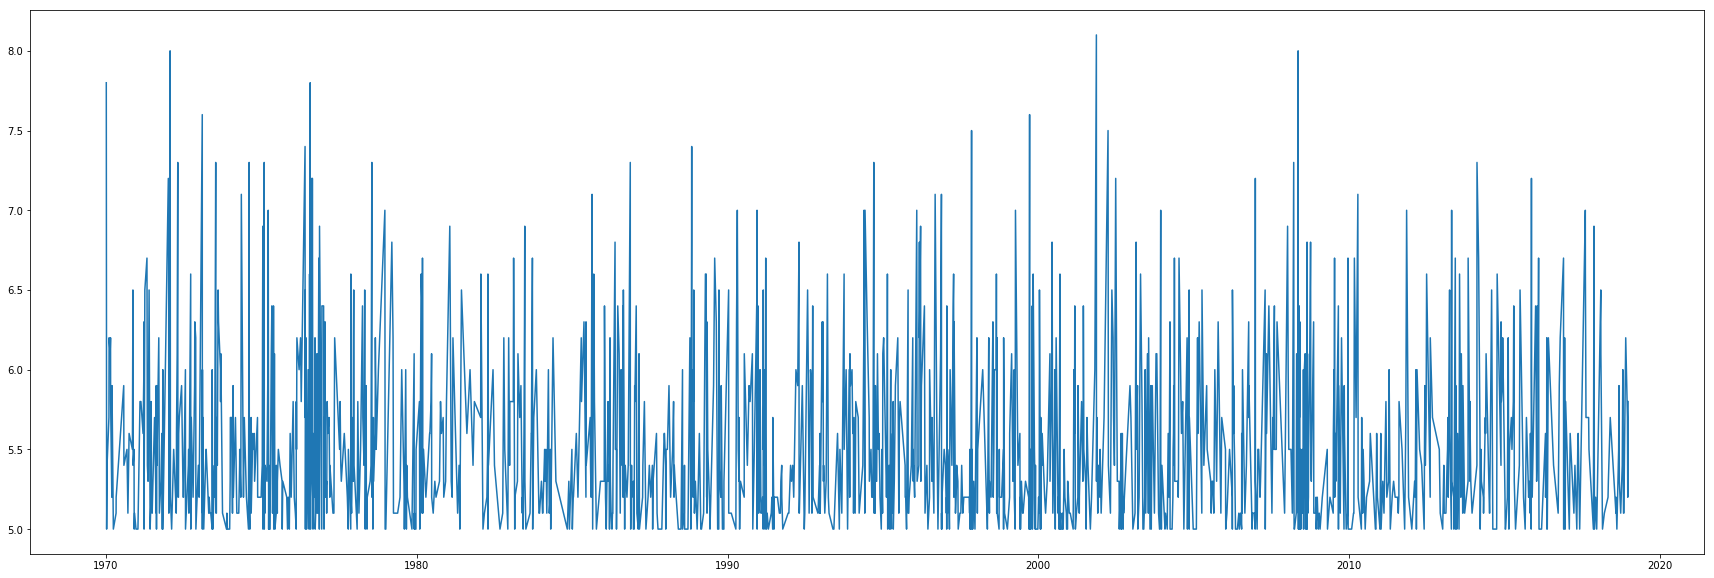

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# # 取5年的地震数据作为一个切片
# sub_slice1 = df_eq_date.loc['1970-01':'1975-01']
# train_slice1 = df_eq_date.loc['1970-01':'1973-12']
# test_slice1 = df_eq_date.loc['1974-01':'1975-01']
plt.figure(figsize=(30,10))
print(df_eq_date)
plt.plot(df_eq_date)
plt.show()

### 2.1  尝试差分处理
消除时间序列数据中所包含的随机性趋势，以令**时间序列数据平稳**，一般使用一阶/二阶差分   
- 差分运算就是后一时间点减去当前时间如y(t)-y(t-1)，用D表示，定义为Dy(t)=y(t) - yt - 1。
- 那么k阶差分可表示为：y(t)-y(t-k)=D(k)*y(t)=(1-L^k)*y(t)=y(t)-(L^k)*y(t)，L为滞后算子，定义为L*y(t)=y(t-1)，则k阶之后算子定 义为(L^k)*y(t)= y(t-k)。

In [78]:
# 一阶差分
df_eq_max['eq_diff_1'] = df_eq_max['震级'].diff(1)
# 差分后出现了NaN，导致plt可视化时报错，进一步处理NaN值，去除即可
df_eq_max['eq_diff_1'].dropna(axis=0, how='any', inplace=True)
df_eq_max['eq_diff_1'].isnull().any() # 判断列是否有 NaN -> False 无

False

In [79]:
# 二阶差分
df_eq_max['eq_diff_2'] = df_eq_max['eq_diff_1'].diff(1)
df_eq_max['eq_diff_2'].dropna(axis=0, how='any', inplace=True)
df_eq_max['eq_diff_2'].isnull().any()

False

In [81]:
# 去除差分后的NaN
df_eq_max.dropna(axis=0, how='any', inplace=True)
df_eq_max

,年,月,日,震级,国内外,eq_diff_1,eq_diff_2
date_time,,,,,,,
1970-01-14,1970,1,14,5.4,国内,0.4,3.2
1970-02-05,1970,2,5,5.7,国内,0.3,-0.1
1970-02-07,1970,2,7,6.2,国内,0.5,0.2
1970-02-19,1970,2,19,6.1,国内,-0.1,-0.6
1970-02-24,1970,2,24,6.2,国内,0.1,0.2
...,...,...,...,...,...,...,...
2018-11-04,2018,11,4,5.1,国内,0.0,0.6
2018-11-26,2018,11,26,6.2,国内,1.1,1.1
2018-12-16,2018,12,16,5.7,国内,-0.5,-1.6


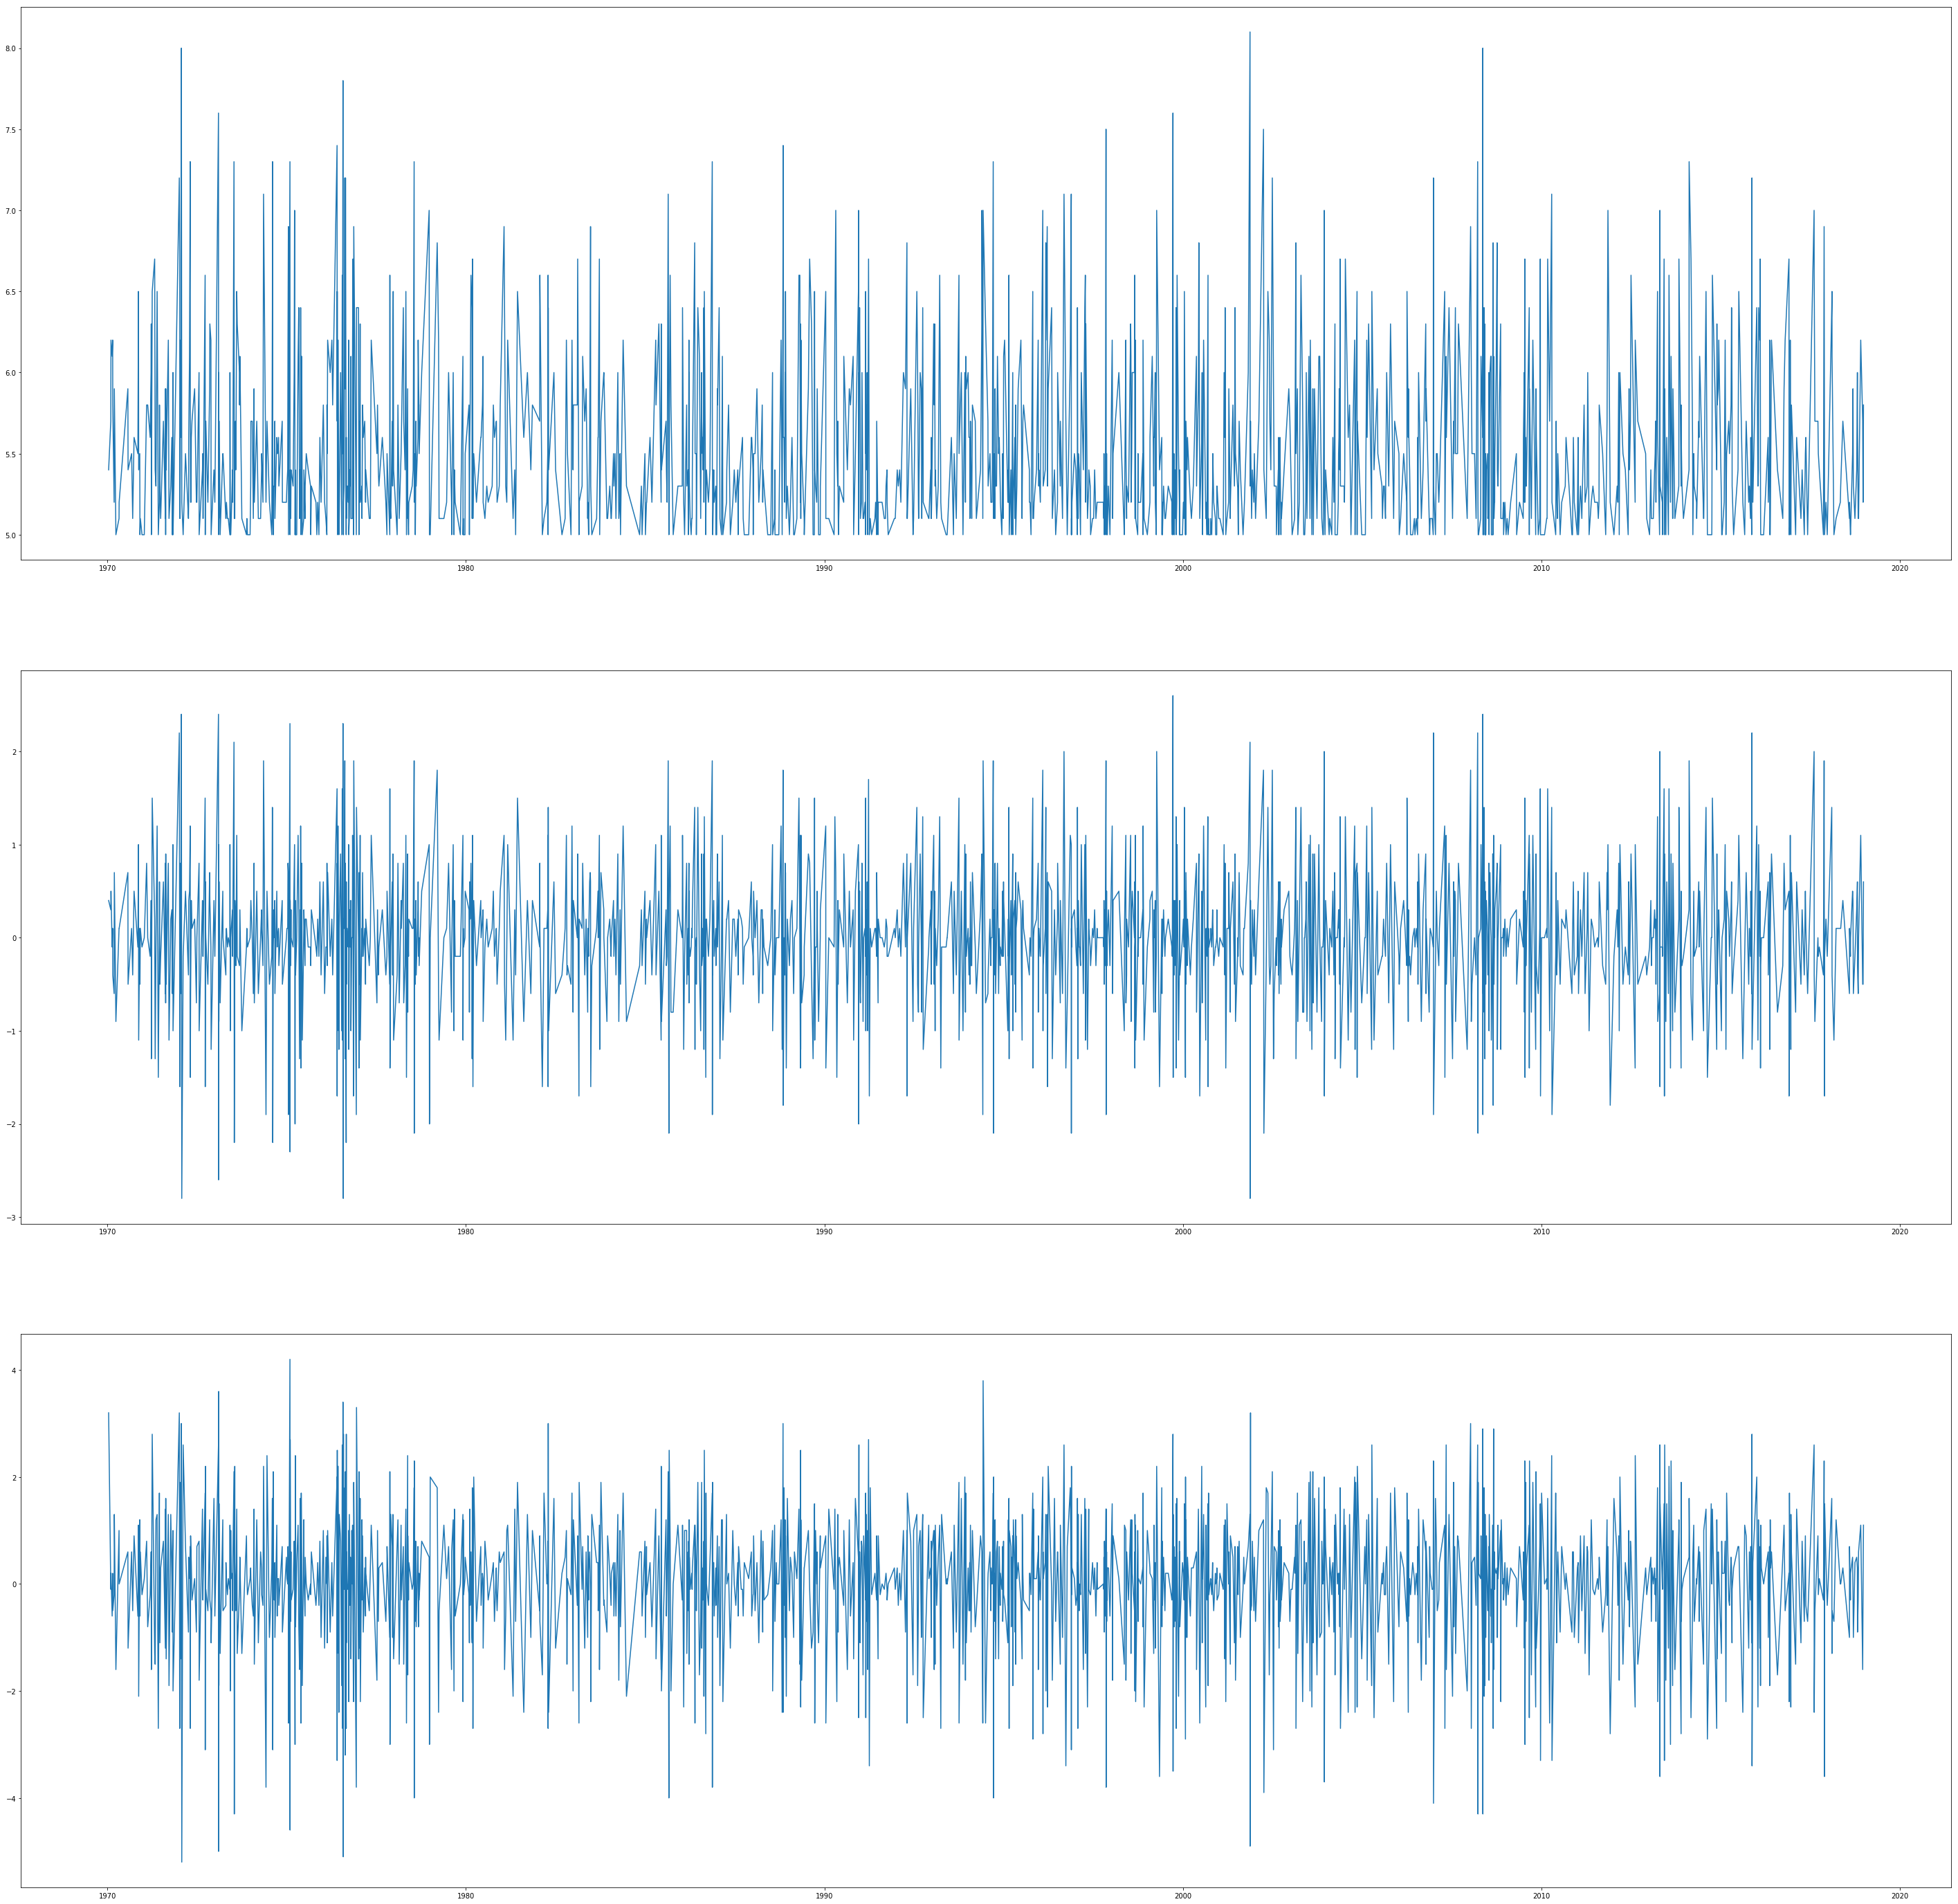

In [82]:
# 全部数据 一阶、二阶差分可视化 （图上来看一阶、二阶差分效果差不多）
fig = plt.figure(figsize=(50,50))
ax1 = fig.add_subplot(311) # “131”表示“1×3网格，第一子图”
ax1.plot(df_eq_max['震级'])
ax2 = fig.add_subplot(312)
ax2.plot(df_eq_max['eq_diff_1'])
ax3 = fig.add_subplot(313)
ax3.plot(df_eq_max['eq_diff_2'])
plt.show()

### 2. 2 不进行差分处理 -> 平稳性检验
观察日期-震级折线图，能看出其没有固定的上升或下降的趋势，粗略判断是平稳序列，故**不进行差分操作**,使用**ADF单位根平稳型检验**，对序列进行平稳性检验
- 1%、%5、%10不同程度拒绝原假设的统计值和ADF df_eq_date result的比较，ADF df_eq_date result同时小于1%、5%、10%即说明非常好地拒绝该假设.本数据中，adf结果为-38.51， 小于三个level的统计值。
- P-value是否非常接近0.本数据中，P-value 为 0.0  

ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为**数据平稳**。

In [43]:
from statsmodels.tsa.stattools import adfuller as ADF
ADF(df_eq_date)
#返回值依次为adf、pvalue、usedlag、nobs、critical values、icbest、regresults、resstore

(-38.515414495370315,
 0.0,
 0,
 1548,
 {'1%': -3.4345813803729857,
  '10%': -2.567764970671501,
  '5%': -2.863408896544693},
 2533.607244925878)

### 3. 绘制数据的自相关图（ACF）和偏自相关图（PACF）
由python的statsmodes库绘制，由差分处理后绘制的ACF、PACF图可以看出：自相关系数（ACF）1阶截尾，偏自相关系数（PACF）拖尾，因此可以选择的是MA(1)，备选ARMA(1，1) 
- 截尾：在大于某个常数k后快速趋于0为k阶截尾
- 拖尾：始终有非零取值，不会在k大于某个常数后就恒等于零(或在0附近随机波动) 

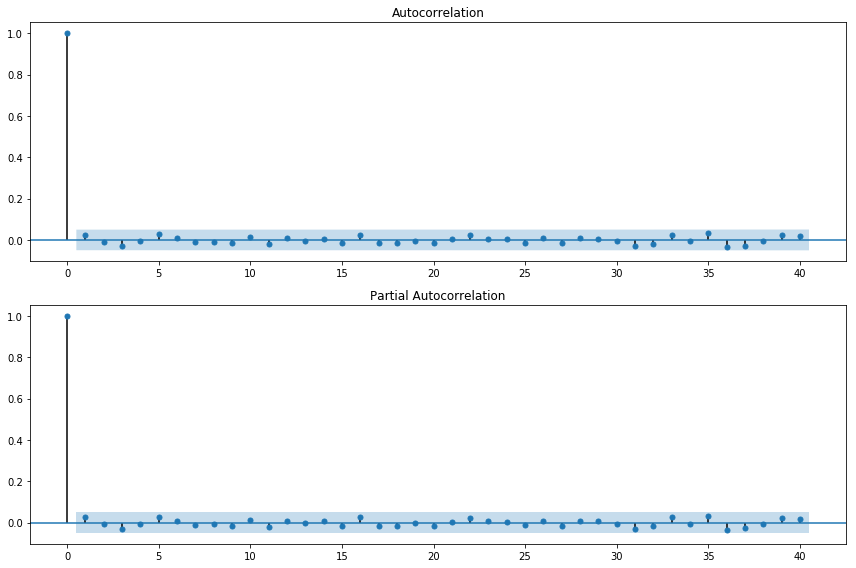

In [44]:
# 不进行差分处理绘制的
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_eq_date, lags=40,ax=ax1) # 绘制自相关图，延迟值设置为20，y轴表示相关性（-1，1）
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_eq_date, lags=40, ax=ax2) # 绘制偏自相关图，延迟值设置为20
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()

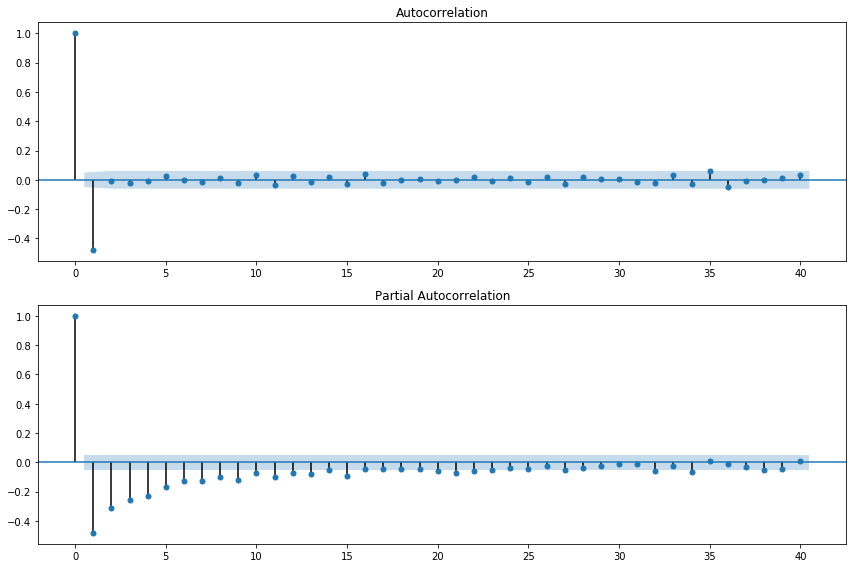

In [93]:
# 进行差分处理后绘制
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_eq_max['eq_diff_1'], lags=40,ax=ax1) # 绘制自相关图，延迟值设置为20，y轴表示相关性（-1，1）
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_eq_max['eq_diff_1'], lags=40, ax=ax2) # 绘制偏自相关图，延迟值设置为20
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()

### 4. 选择模型计算aic，bic,hqic
根据ARMA模型的特征系数选取方法选择模型，并计算不同模型的aic，bic，hqic。取值最小的模型ARMA（1，1）

In [87]:
# 不做差分处理 （结果来看 MA（1）最佳）
arma_mod1 = sm.tsa.ARMA(df_eq_date,(0,1)).fit() # MA（1）
print(arma_mod1.aic, arma_mod1.bic, arma_mod1.hqic)
arma_mod2 = sm.tsa.ARMA(df_eq_date,(1,1)).fit() # ARMA（1，1）
print(arma_mod2.aic, arma_mod2.bic, arma_mod2.hqic)
arma_mod3 = sm.tsa.ARMA(df_eq_date,(1,0)).fit() # AR(1)
print(arma_mod3.aic, arma_mod3.bic, arma_mod3.hqic)

2583.4433767266023 2599.479471247853 2589.40779360861
2585.4240716019553 2606.805530963623 2593.3766274446325
2583.459618264743 2599.4957127859934 2589.4240351467506


D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [92]:
# 做了差分处理 （结果来看 MA（1）最佳）
arma_mod4 = sm.tsa.ARMA(df_eq_max['eq_diff_1'],(0,1)).fit() # MA（1）
print(arma_mod4.aic, arma_mod4.bic, arma_mod4.hqic)
arma_mod5 = sm.tsa.ARMA(df_eq_max['eq_diff_1'],(1,1)).fit() # ARMA（1，1）
print(arma_mod5.aic, arma_mod5.bic, arma_mod5.hqic)
arma_mod6 = sm.tsa.ARMA(df_eq_max['eq_diff_1'],(1,0)).fit() # AR(1)
print(arma_mod6.aic, arma_mod6.bic, arma_mod6.hqic)

D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2571.808768003779 2587.840986555498 2577.7721294418347
2572.5814292050013 2593.9577206072936 2580.5325777890757
3185.547123241762 3201.5793417934815 3191.510484679818


D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 5. 模型验证
- 残差验证（对选定的ARMA模型所产生的残差做自相关图）
- 德宾-沃森（D-W）检验（是否存在自相关性）
- qq图（是否符合正态分布）

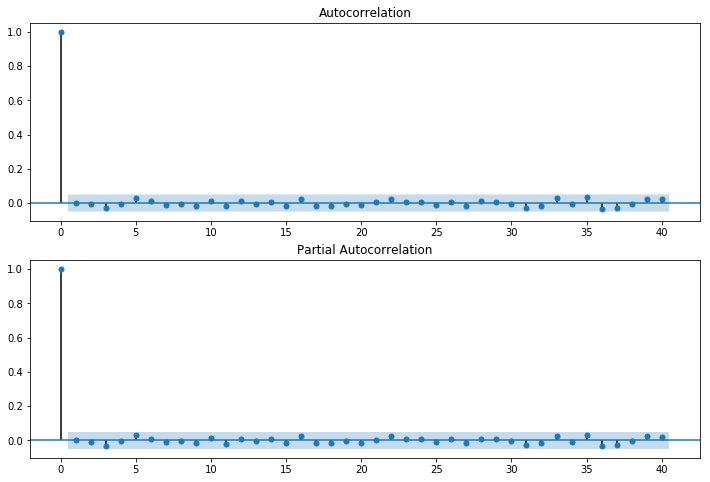

In [99]:
# 不做差分处理-残差验证
resid = arma_mod1.resid 
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40,ax=ax2)

In [100]:
# 德宾-沃森（D-W）检验
print(sm.stats.durbin_watson(arma_mod4.resid.values))
# 1.9419050789035992 -> 残差不存在自相关性


1.9419050789035992


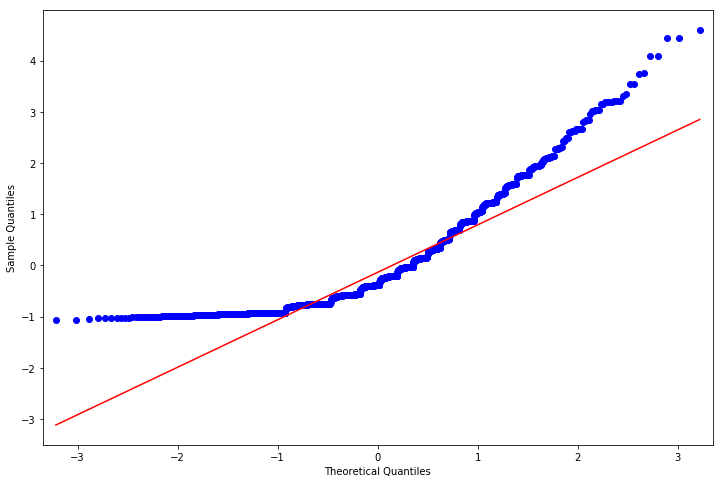

In [101]:
from statsmodels.graphics.api import qqplot
# 观察是否符合正态分布,这里用qq图
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q',ax=ax, fit=True)

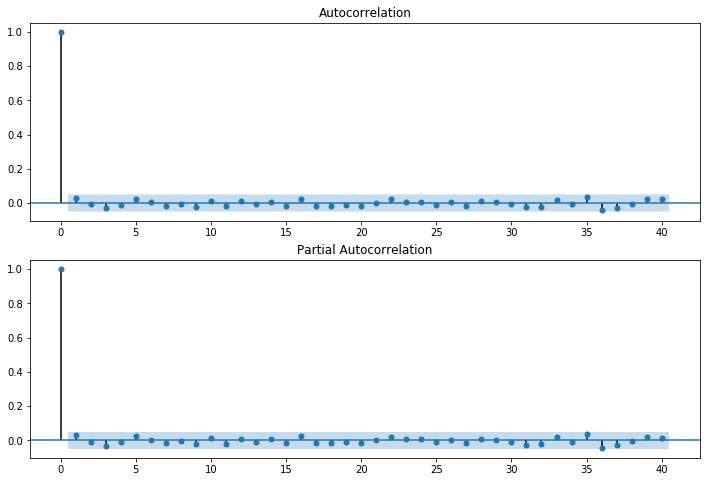

In [102]:
# 做了差分处理-残差验证
resid = arma_mod4.resid 
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40,ax=ax2)

In [104]:
# 德宾-沃森（D-W）检验
print(sm.stats.durbin_watson(arma_mod4.resid.values))
# 1.9419050789035992 -> 残差不存在自相关性


1.9419050789035992


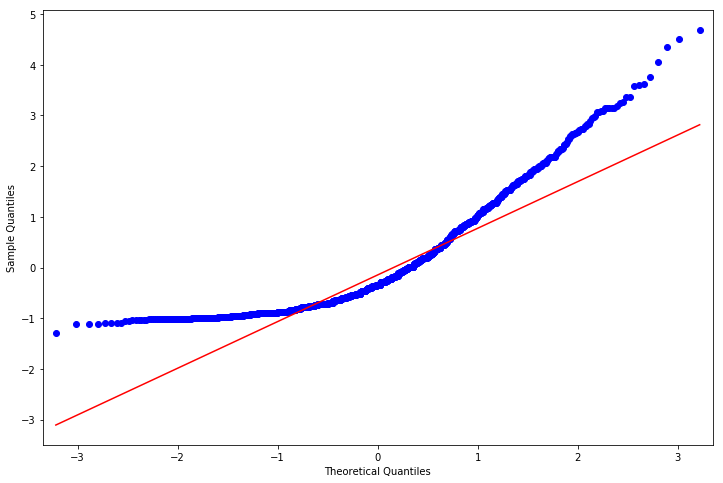

In [105]:
from statsmodels.graphics.api import qqplot
# 观察是否符合正态分布,这里用qq图
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q',ax=ax, fit=True)

In [51]:
# 根据AIC、BIC自动选择最佳模型
train_results = sm.tsa.arma_order_select_ic(df_eq_date, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
 
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)
#AIC（1，1）、BIC（1，1） -> 选择ARMA(1,1)模型

D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInve

AIC (1, 1)
BIC (1, 1)


D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [106]:
# 根据AIC、BIC自动选择最佳模型
train_results = sm.tsa.arma_order_select_ic(df_eq_max['eq_diff_1'], ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
 
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)
#AIC（0，1）、BIC（0，1） -> 选择MA(1)模型

D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda\envs\skl

AIC (0, 1)
BIC (0, 1)


D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### 6. 模型预测

D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


date_time
1970-02-05   -0.000045
1970-02-07   -0.150068
1970-02-19   -0.433424
1970-02-24   -0.250114
1970-02-25   -0.280136
                ...   
2018-11-04    0.391817
2018-11-26    0.391518
2018-12-16   -0.708069
2018-12-20   -0.207979
2018-12-24    0.291786
Length: 1546, dtype: float64


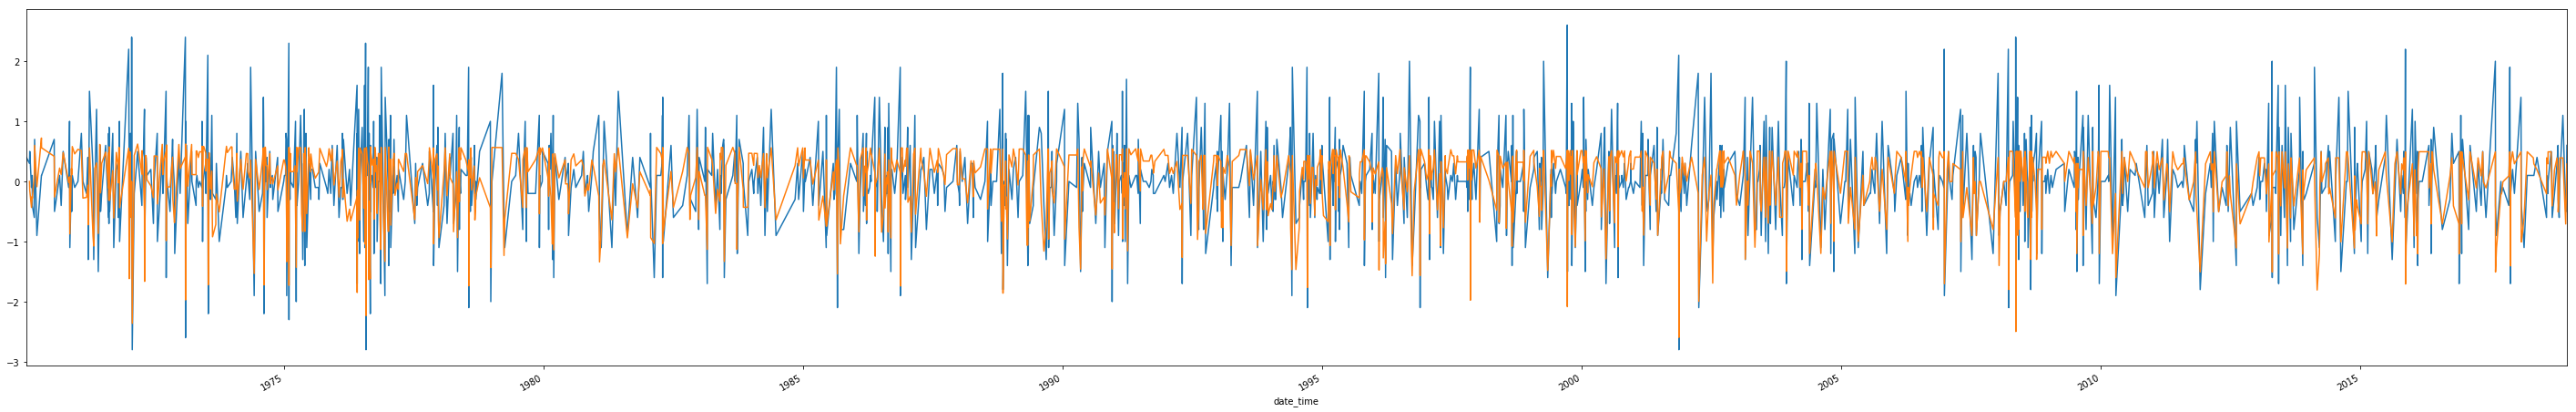

In [132]:
# 一阶差分处理
model = sm.tsa.ARIMA(df_eq_max['震级'], order=(0, 1, 1)) # MA(1）模型 ，指定一阶差分
results = model.fit()
predict_sunspots = results.predict(dynamic=False)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(50, 8))
ax = df_eq_max['eq_diff_1'].plot(ax=ax)
predict_sunspots.plot(ax=ax)
plt.show()

D:\Anaconda\envs\sklearn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


date_time
1970-01-14    5.527152
1970-02-05    5.523465
1970-02-07    5.532276
1970-02-19    5.546532
1970-02-24    5.543216
                ...   
2018-11-04    5.514621
2018-11-26    5.515119
2018-12-16    5.547030
2018-12-20    5.531592
2018-12-24    5.517528
Length: 1547, dtype: float64


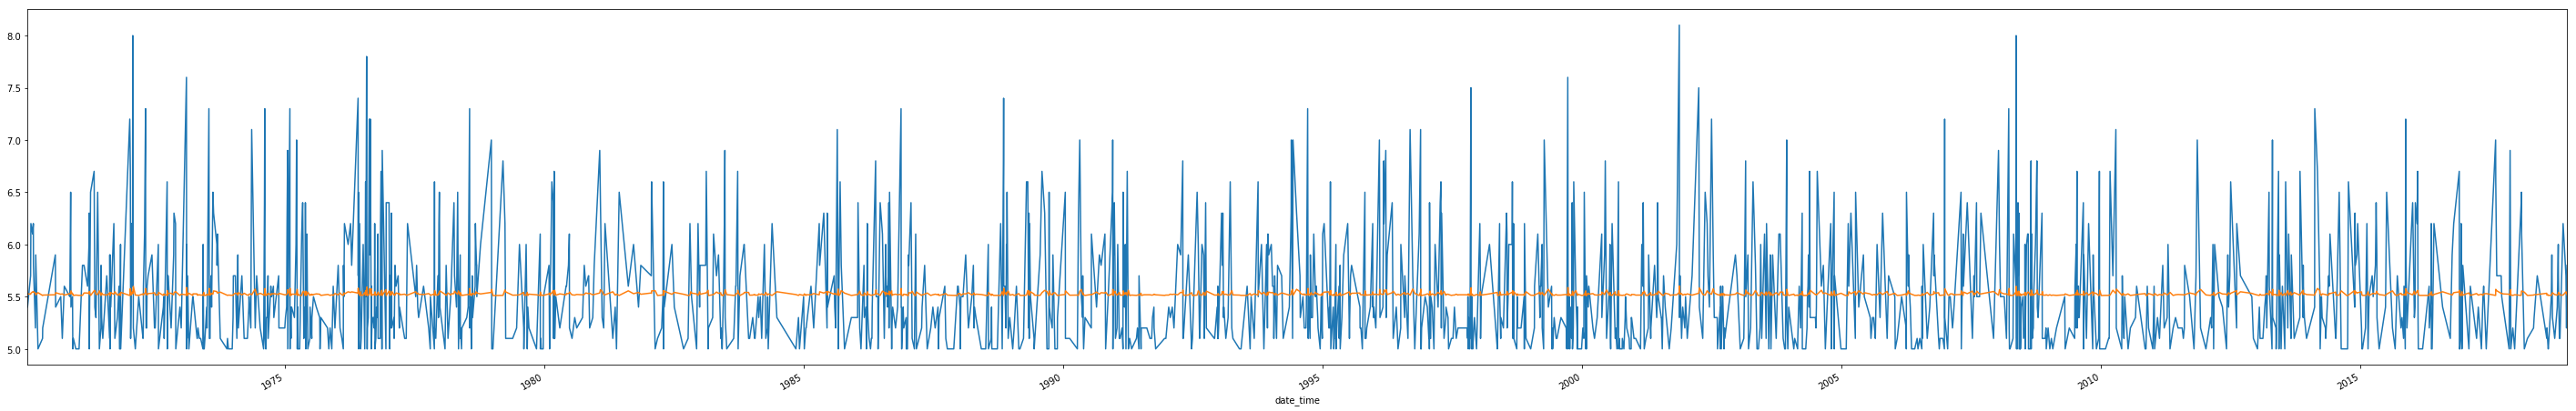

In [137]:
# 不做差分处理
model2 = sm.tsa.ARIMA(df_eq_max['震级'], order=(0, 0, 1)) # MA(1）模型 
results2 = model2.fit()
predict_sunspots = results2.predict(dynamic=False)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(50, 8))
ax = df_eq_max['震级'].plot(ax=ax)
predict_sunspots.plot(ax=ax)
plt.show()

In [136]:
# 预测下一个震级 （做了一阶差分处理）
results.forecast()[0] 

array([5.49174347])

In [138]:
results2.forecast()[0] 

array([5.53535038])